In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tqdm
import time
from PIL import Image
from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.models
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN

path = "/content/drive/My Drive/APS360 Project/v6-dataset/"

In [3]:
if torch.cuda.is_available():
    print("CUDA activated")
    use_cuda = True
    device = torch.device("cuda")
    
else:
    print("Using CPU")
    device = "cpu"

CUDA activated


In [20]:
# Get the type of GPU

!nvidia-smi

Wed Apr  1 02:02:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    34W / 250W |   2655MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# These ae the classes we will be training in our model

classes = ["Apple",
           "Bagel",
           "Banana",
           "Bread",
           "Broccoli",
           "Burrito",
           "Carrot",
           "Cheese",
           "Coffee",
           "Cookie",
           "Cucumber",
           "Egg (Food)",
           "French fries",
           "Grape",
           "Hamburger",
           "Hot dog",
           "Juice",
           "Lemon",
           "Lobster",
           "Muffin",
           "Orange",
           "Pancake",
           "Pasta",
           "Pear",
           "Pizza",
           "Potato",
           "Salad",
           "Sandwich",
           "Strawberry",
           "Taco",
           "Tomato",
           "Waffle"]

In [6]:
filePath = os.path.join(path, 'tester')
print(filePath)

/content/drive/My Drive/APS360 Project/v6-dataset/tester


In [0]:
test_data = torchvision.datasets.ImageFolder(filePath,
                                             loader=plt.imread,
                                             transform=transforms.ToTensor())

In [22]:
test_data

Dataset ImageFolder
    Number of datapoints: 8
    Root location: /content/drive/My Drive/APS360 Project/v6-dataset/tester
    StandardTransform
Transform: ToTensor()

In [9]:
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 200),),aspect_ratios=((0.5, 1.0, 2.0),))
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],output_size=7,sampling_ratio=2)
rcnn1 = FasterRCNN(backbone,num_classes=32,rpn_anchor_generator=anchor_generator,box_roi_pool=roi_pooler).cuda()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


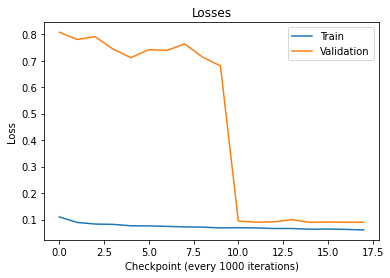

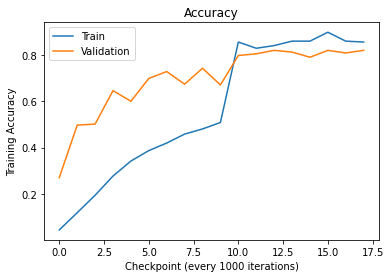

In [10]:
checkpointPath = os.path.join(path, 'faster-rcnn-checkpoints', "bs6_lr0.0001_epoch3_checkpoint_17.pth")
checkpoint = torch.load(checkpointPath)
rcnn1.load_state_dict(checkpoint['model_state_dict'])
rcnn1.eval()

saved_x = checkpoint['saved_x']
saved_train_losses = checkpoint['saved_train_loss']
saved_val_losses = checkpoint['saved_val_loss']
train_acc = checkpoint['train_acc']
val_acc = checkpoint['val_acc']

plt.title("Losses")
plt.plot(saved_x, saved_train_losses, label="Train")
plt.plot(saved_x, saved_val_losses, label='Validation')
plt.xlabel("Checkpoint (every 1000 iterations)")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("Accuracy")
plt.plot(saved_x, train_acc, label="Train")
plt.plot(saved_x, val_acc, label="Validation")
plt.xlabel("Checkpoint (every 1000 iterations)")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

In [11]:
print(train_acc[-1])
print(val_acc[-1])

0.8544061302681992
0.8185185185185185


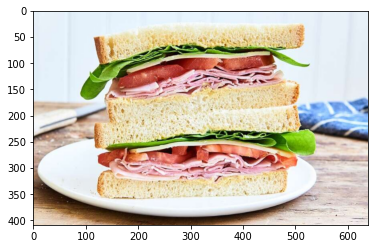

In [12]:
img_show = []
height = []
width = []
for i in range(len(test_data)):
    img_show.append(plt.imread(test_data.imgs[i][0]))
    height.append(img_show[-1].shape[0])
    width.append(img_show[-1].shape[1])
    plt.imshow(img_show[-1])

In [23]:
result = []
with torch.no_grad():
    for i in range(len(test_data)):
        print(i)
        result.append(rcnn1([test_data[i][0].cuda()]))

0
1
2
3
4
5
6
7


In [0]:
def intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]


def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

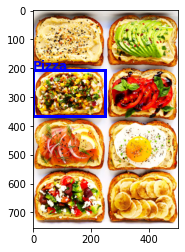

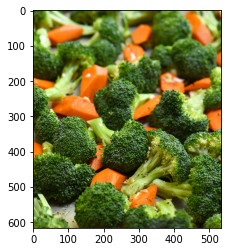

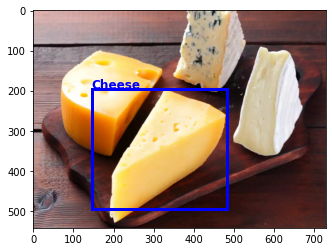

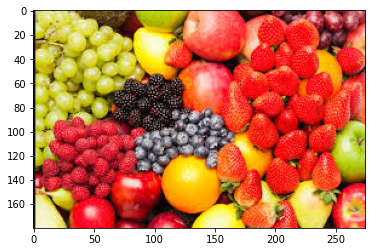

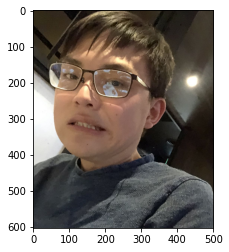

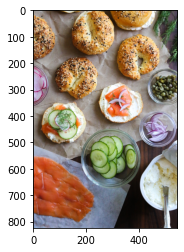

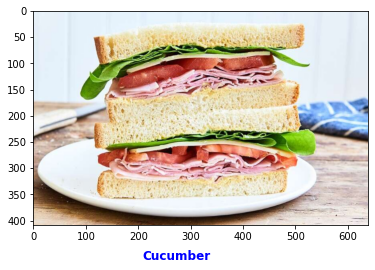

IndexError: ignored

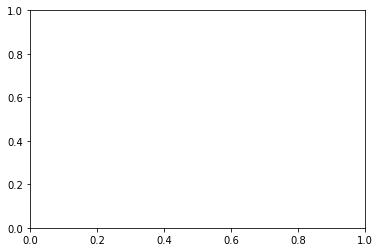

In [25]:
for i in range(len(test_data)):
    first_box = result[i][0]['boxes'][0].unsqueeze(0)
    box_id = 0
    plt.cla()
    plt.imshow(img_show[i])

    overlap = 0.8
    confidence = 0.3
    for box in result[i][0]['boxes']:
        if (box_id==0 or jaccard(first_box,box.unsqueeze(0)).tolist()[0][0]<overlap):
            if result[i][0]['scores'].tolist()[box_id]>=confidence:
                x1 = int(box[0])
                y1 = int(box[1])
                x2 = int(box[2])
                y2 = int(box[3])
                #check other boxes
                flag = True
                for each in range(result[i][0]['boxes'].shape[0]):
                    if each!=box_id and result[i][0]['scores'].tolist()[each]>=confidence and jaccard(first_box,result[i][0]['boxes'][each].unsqueeze(0)).tolist()[0][0]<overlap:
                            o_x1 = int(result[i][0]['boxes'][each][0])
                            o_y1 = int(result[i][0]['boxes'][each][1])
                            o_x2 = int(result[i][0]['boxes'][each][2])
                            o_y2 = int(result[i][0]['boxes'][each][3])
                            if x1>=o_x1-3 and y1>=o_y1-3 and x2<=o_x2+3 and y2<=o_y2+3 and result[i][0]['labels'][box_id]==result[i][0]['labels'][each]:
                                flag = False
                                break
                                
                if flag:
                    plt.gca().add_patch(plt.Rectangle((x1, y1),x2 - x1,y2 - y1, fill=False, edgecolor='b',linewidth=3))
                    plt.text(x1,y1,classes[result[i][0]['labels'][box_id]], color='blue',fontsize=12,weight='bold')
        box_id += 1
    plt.show() 